<br>$$ {定义模拟退火父类SimulatedAnnealingBase} $$</br>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


# 定义模拟退火父类
class SimulatedAnnealingBase():
    """
    DO SA(Simulated Annealing)

    Parameters
    ----------------
    func : function
        The func you want to do optimal
    n_dim : int
        number of variables of func
    x0 : array, shape is n_dim
        initial solution
    T_max :float
        initial temperature
    T_min : float
        end temperature
    L : int
        num of iteration under every temperature（Long of Chain）

    """

    # 父类的初始化函数
    def __init__(self, func, x_min, x_max, T_max=1e2, T_min=1e-7, L=300, max_stay_counter=300, alpha=0.7, **kwargs):
        '''

        :param func:
        :param x_init:
        :param T_max:
        :param T_min:
        :param L:
        :param max_stay_counter:
        :param kwargs:

        '''
        self.x_min, self.x_max = x_min, x_max
        self.x_init = self.x_min + np.random.rand() * (self.x_max - self.x_min)
        assert T_max > T_min > 0, 'T_max > T_min > 0'
        self.name = 'SimulatedAnnealingBase'
        self.func = func  # 目标函数
        self.T_max = T_max  # 起始温度
        self.T_min = T_min  # 终止温度
        self.L = int(L)  # 每个温度下的最大迭代次数（马尔科夫链长度）
        # 在 best_y 保持不变次数超过 max_stay_counter 时停止
        self.max_stay_counter = max_stay_counter

        self.n_dims = len(self.x_init)  # func所需要输入的变量个数

        self.best_x = np.array(self.x_init)  # 初始点
        self.best_y = self.func(self.best_x)  # 初始化 best_y
        self.T = self.T_max  # 初始化当前温度
        self.iter_cycle = 0  # 初始化小循环次数
        self.total_counter = 0  # 初始化总迭代次数
        self.generation_best_X, self.generation_best_Y = [self.best_x], [self.best_y]  # 初始化每个阶段 best_x, best_y 的记录列表
        self.generation_T = [self.T]

        # 历史结果（供研究退火过程，可弃用）
        self.best_x_history, self.best_y_history = [self.best_x], [self.best_y]
        self.T_history = [self.T]
        self.total_counter_history = [0]
        self.x_iter_history = []
        self.alpha = alpha

    # 产生新解
    def get_new_x(self, x):
        u = np.random.uniform(-1, 1, size=self.n_dims)
        x_new = x + 20 * np.sign(u) * self.T * ((1 + 1.0 / self.T) ** np.abs(u) - 1.0)
        return x_new

    # 降温方式
    def cool_down(self):
        self.T = self.T * self.alpha

    # 接受准则
    def judge(self, df):
        '''

        :param df:
        :return:

        '''
        if df < 0:  # 新解 < 原解 ---> 直接接受
            return True
        else:
            p = np.exp(-1 * (df / self.T))  # 新解 > 原解 ---> 计算接受概率p
            rand_p = random.random()  # 产生 rand_p ~ Uniform(0, 1)
            if p > rand_p:
                return True
            else:
                return False

    # 辅助进行终止条件判断的函数
    def isclose(self, a, b, rel_tol=1e-09, abs_tol=1e-30):
        '''

        :param a:
        :param b:
        :param rel_tol:
        :param abs_tol:
        :return:

        '''
        return abs(a - b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)  #

    # 主程序
    def run(self):
        '''

        :return:

        '''
        x_current, y_current = self.best_x, self.best_y  # 初始化 x_current, y_current
        stay_counter = 0  # 初始化小循环次数
        self.total_counter = 0  # 初始化总迭代次数
        while True:  # 迭代
            x_iter_list = []
            for i in range(self.L):  # 等温阶段
                # 产生新解
                x_new = self.get_new_x(x_current)
                y_new = self.func(x_new)
                x_iter_list.append(abs(x_new-x_current))

                # 接受准则，Metropolis准则
                df = y_new - y_current  # 计算函数值差值
                if self.judge(df):  # 根据接受准则判断是否接受
                    self.total_counter += 1
                    x_current, y_current = x_new, y_new  # 更新 x_current, y_current

                    # 记录退火过程（可弃用）
                    self.total_counter_history.append(self.total_counter)
                    self.best_x_history.append(x_current)
                    self.best_y_history.append(y_current)
                    self.T_history.append(self.T)

                    if y_new < self.best_y:  # 判断是否更新best_x, best_y
                        self.best_x, self.best_y = x_new, y_new

            self.iter_cycle += 1  # 更新小循环次数
            self.cool_down()  # 降温
            self.x_iter_history.append(sum(x_iter_list)/len(x_iter_list))
            # 更新该等温阶段的 best_x, best_y
            self.generation_best_Y.append(self.best_y)
            self.generation_best_X.append(self.best_x)
            self.generation_T.append(self.T)

            # 两种终止判断条件

            # 1. best_y 长时间不变 ---> 停止迭代
            if len(self.best_y_history) > 1:
                if self.isclose(self.best_y_history[-1], self.best_y_history[-2]):
                    stay_counter += 1
                else:
                    stay_counter = 0

            # 2. 当前温度 < 最低温度 ---> 停止迭代
            if self.T < self.T_min:
                stop_code = 'Cooled to final temperature'
                break
            if stay_counter > self.max_stay_counter:
                stop_code = 'Stay unchanged in the last {stay_counter} iterations'.format(stay_counter=stay_counter)
                break

        print("Number of iteration: ", self.iter_cycle * self.L)
        print(stop_code)
        return self.best_x, self.best_y

    def draw(self):  # 可视化
        '''

        :return:

        '''
        if self.best_x.shape[0] == 1:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            x0_list = []
            for i in self.generation_best_X:
                x0_list.append(i[0])
            x_min, x_max = min(x0_list), max(x0_list)
            x = np.arange(x_min, x_max, 0.001)
            y = np.zeros(shape=x.shape)
            for index in range(x.shape[0]):
                y[index] = self.func(np.array([x[index]]))
            plt.plot(x, y)
            for i in range(len(self.generation_best_X)):
                x0, y0, t = self.generation_best_X[i], self.generation_best_Y[i], self.generation_T[i]
                plt.title("当前温度 ： {}".format(str(t) + "\n" + "\n" + "当前解 ： {}".format(str(x0))))
                p = ax.scatter(x0, y0, marker='o')
                # plt.pause(0.01)
                if i != len(self.generation_best_X) - 1:
                    p.remove()


            ax.plot(self.generation_best_X, self.generation_best_Y)
            # for j in range(len(self.generation_best_X)):
            #     lines = ax.plot(self.generation_best_X[:j], self.generation_best_Y[:j], c='r')
            #     plt.pause(0.1)
            #     ax.lines.pop(1)

            plt.show()

        elif self.best_x.shape[0] == 2:
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            x0_list = []
            x1_list = []
            for i in self.generation_best_X:
                x0_list.append(i[0])
                x1_list.append(i[1])
            x_min, x_max = min(x0_list), max(x0_list)
            y_min, y_max = min(x1_list), max(x1_list)
            x = np.arange(x_min, x_max, 0.01)
            y = np.arange(y_min, y_max, 0.01)
            X, Y = np.meshgrid(x, y)
            Z = self.func(np.array([X, Y]))
            ax.plot_surface(X, Y, Z, cmap='rainbow', alpha=0.3)
            
            ax.scatter(x0_list[-1], x1_list[-1], self.generation_best_Y[-1], c='b', marker='o')

#             for i in range(len(self.generation_best_X)):
#                 x0, x1, y, t = x0_list[i], x1_list[i], self.generation_best_Y[i], self.generation_T[i]
#                 plt.title("当前温度 ： {}".format(str(t) + "\n" + "\n" + "当前解 ： {}".format(str(x0) + "," + str(x1))))
#                 p = ax.scatter(x0, x1, y, c='b', marker='o')
#                 p = ax.plot(x0, x1, c='b', marker='o')
                # plt.pause(0.01)
#                 if i != len(self.generation_best_X) - 1:
#                     p.remove()

            plt.show()

    def plot(self):
        fig = plt.figure()
        ax1 = fig.add_subplot(211)
        plt.title(self.name)
        ax2 = fig.add_subplot(212)
        counters1 = np.array([counter for counter in range(1, self.iter_cycle + 2)])
        ax1.plot(counters1, self.generation_T)
        ax1.set_xlabel("迭代次数")
        ax1.set_ylabel("温度")
        counters2 = np.array([counter for counter in range(1, self.iter_cycle + 1)])
        ax2.plot(counters2, np.array(self.x_iter_history))
        ax2.set_xlabel("迭代次数")
        ax2.set_ylabel(r'$|x|$的平均扰动')
        plt.show()

<br>$$ {定义模拟退火子类SADemo} $$</br>
<br></br>
<br><font size=5 >**初始化参数**</font><br/>
<br><br/>
	<br>&emsp;&emsp;**初始温度**<br/>
   <br>&emsp;&emsp;&emsp;&emsp;温度越高准确率和精确度越高，相应地，计算时间会变长</br>
   <br>$$ \boxed{T_0 = 10^2} $$</br>
   <br></br>
	<br>&emsp;&emsp;**初始解**</br>
	<br>&emsp;&emsp;&emsp;&emsp;随机扰动生成</br>
   <br>$$ \boxed{x_{0} = x_{min} + (x_{max} - x_{min})*rand(0,1)} $$<br>
	<br></br>
	<br>&emsp;&emsp;**搜索范围**<br>
   <br>&emsp;&emsp;&emsp;&emsp;给出各个元素的取值范围</br>
   
   
<br><font size=5 >**等温过程**</font><br/>
<br><br/>
    <br>&emsp;&emsp;**产生新解**<br/>
    <br>$$ \boxed{x_{new} = x_{curr} + \frac{1}{2}(x_{max} - x_{min}) * rand()} $$</br>
    <br></br>
    <br>&emsp;&emsp;**Metropolis准则**</br>
    <br>$$ \boxed{\Delta E=f(x_{new}) - f(x_{old})} $$<br>
    <br>$$ \boxed{P =\left\{\begin{aligned}&1 \text{  , if }\Delta E <0\\&e^{-\Delta E/T}\text{  , if }\Delta E >0\end{aligned}\right.} $$<br>
    <br>$$ \boxed{num = rand(0,1)} $$<br>
    <br>$$ \boxed{Judge:\left\{\begin{aligned}x_{curr } = x_{new}\text{  , if num>P}\\\text{get_new_x  
 , if num<P}\end{aligned}\right.} $$<br>
    <br></br>
    <br>&emsp;&emsp;**马尔科夫链长度（小循环次数）**<br>
    <br>$$ \boxed{L = 300} $$</br>
    
    
<br><font size=5 >**降温控参**</font><br/>
<br><br/>
    <br>&emsp;&emsp;**降温条件**<br/>
    <br>&emsp;&emsp;&emsp;&emsp;马尔科夫链长度<br/>
    <br>$$ \boxed{L = 300} $$</br>
    <br></br>
    <br>&emsp;&emsp;**如何降温**</br>
    <br>$$ \boxed{T = T * 0.7} $$<br>


<br><font size=5 >**找到最优解**</font><br/>
<br><br/>
    <br>&emsp;&emsp;**终止条件**<br/>
    <br>$$ \boxed{T < 10^{-7}} $$</br>
   

In [25]:
class SADemo(SimulatedAnnealingBase):
    def __init__(self, func, x_min: np.ndarray, x_max: np.ndarray, T_max=1e2, T_min=1e-7, alpha=0.7, L=300, max_stay_counter=300, **kwargs):
        super().__init__(func, x_min, x_max, T_max, T_min, L, max_stay_counter, alpha,**kwargs)
        self.name = 'SADemo'
    
    def get_new_x(self, x):
        x_new = np.zeros(shape=x.shape)
        for i in range(x.shape[0]):
            u = np.random.uniform(0,1) * (self.x_max[i] - self.x_min[i]) * 0.5
            if x_new[i] + u < self.x_min[i] or x_new[i] + u > self.x_max[i]:
                x_new[i] -= u
            else:
                x_new[i] += u
        return x_new
    
    def cool_down(self):
        self.T = self.T * self.alpha

<br><font size=5 >**函数选择(1/4)**</font><br/>
<br><br/>
	<br>&emsp;&emsp;**函数名：obj_fun1（自制函数）**<br/>
   <br>$$ \boxed{f(x)=|0.2x| + 10sin(5x) + 7cos(x)} $$</br>
   <br></br>
	<br>&emsp;&emsp;**函数特征**</br>
	<br>&emsp;&emsp;&emsp;&emsp;波动程度很大，且局部极小值点与最小值点值十分接近。</br>
	<br></br>
   <br>&emsp;&emsp;**极小值点**</br>
	<br>&emsp;&emsp;&emsp;&emsp;（由于没有解析解（也可能是水平不行，我们求出了精度为1e-20的数值解）：0.8940484541444654</br>
	<br></br>
	<br>&emsp;&emsp;**测试性能**<br>
   <br>&emsp;&emsp;&emsp;&emsp;全局收敛性</br>

<br>$$ {f(x)=|0.2x| + 10sin(5x) + 7cos(x)  (-10< x <10)  } $$</br>

<IPython.core.display.Javascript object>


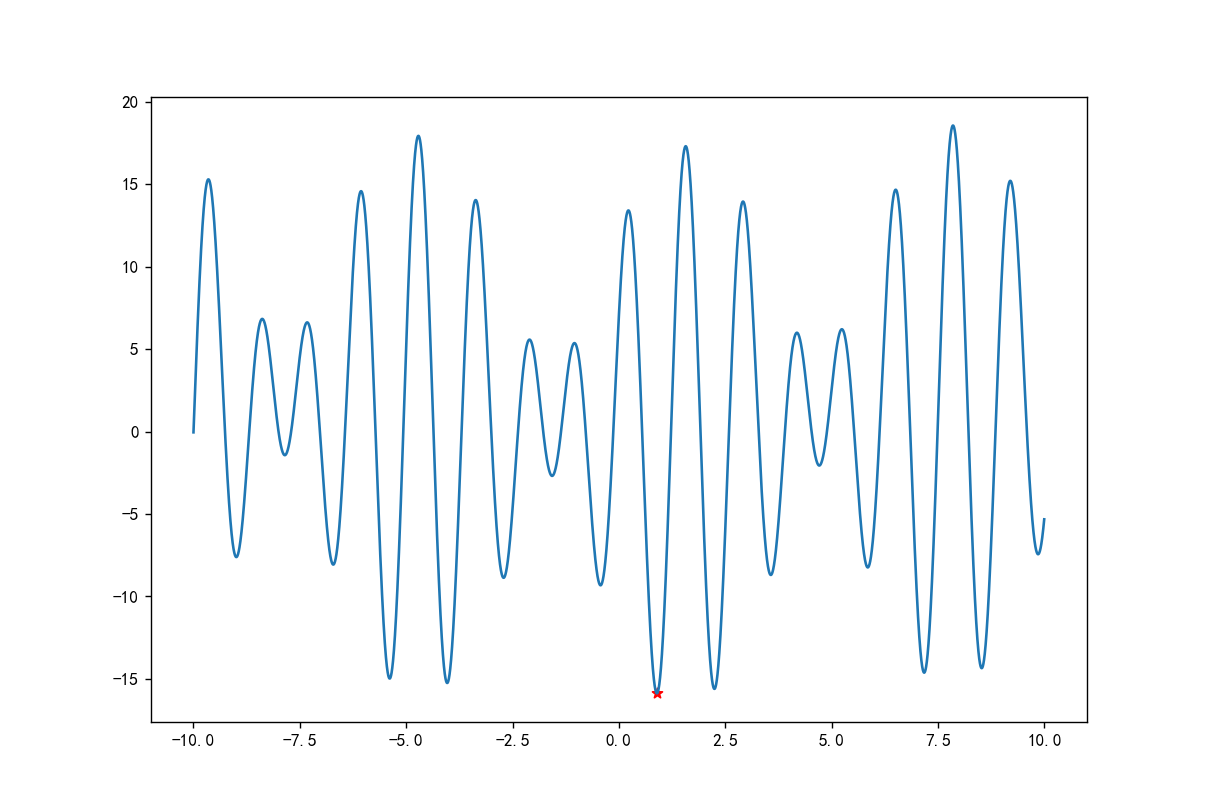

In [26]:
%matplotlib notebook
def obj_fun1(x: np.ndarray):
    return abs(0.2 * x[0]) + 10 * np.sin(5 * x[0]) + 7 * np.cos(4 * x[0])

x = np.arange(-10, 10, 0.001)
y = np.zeros(shape=x.shape)
for i in range(x.shape[0]):
    y[i] = obj_fun1(np.array([x[i]]))
plt.scatter(0.8940484541444654, obj_fun1(np.array([0.8940484541444654])),c='r', marker='*')
plt.plot(x,y)
plt.show()

<br><font size=5 >**函数选择(2/4)**</font><br/>
<br><br/>
	<br>&emsp;&emsp;**函数名：obj_fun2（自制函数）**<br/>
   <br>$$ \boxed{f(x)=0.1x^2-cos(2\pi x) +1} $$</br>
   <br></br>
	<br>&emsp;&emsp;**函数特征**</br>
	<br>&emsp;&emsp;&emsp;&emsp;波动程度很大，且局部极小值点与最小值点值十分接近。</br>
	<br></br>
	<br>&emsp;&emsp;**测试性能**<br>
   <br>&emsp;&emsp;&emsp;&emsp;方法的健壮性（鲁棒性）</br>
   

<IPython.core.display.Javascript object>


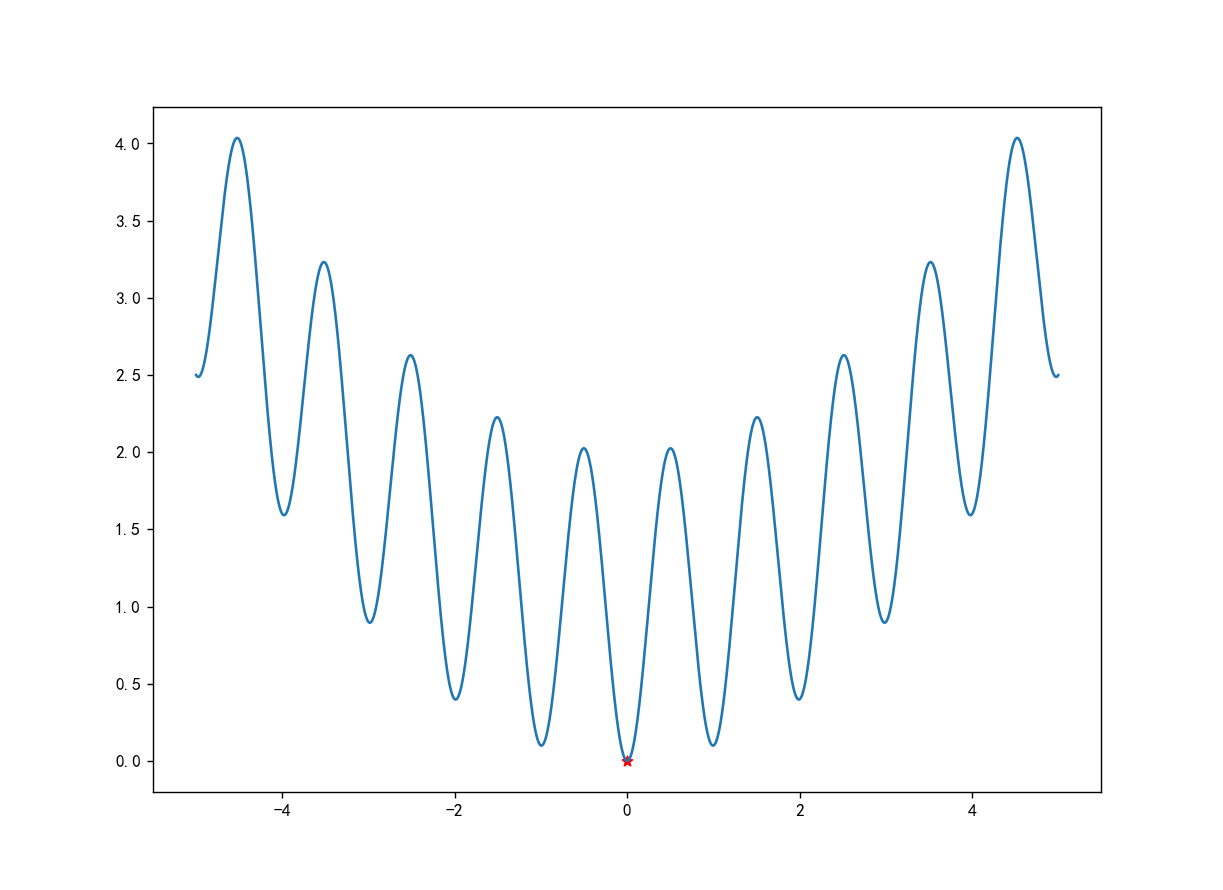

In [4]:
%matplotlib notebook
def obj_fun2(x: np.ndarray):
    return 0.1*x[0]**2 - np.cos(2*np.pi*x[0]) + 1

x = np.arange(-5, 5, 0.001)
y = np.zeros(shape=x.shape)
for i in range(x.shape[0]):
    y[i] = obj_fun2(np.array([x[i]]))
plt.scatter(0, obj_fun2(np.array([0])),c='r', marker='*')
plt.plot(x,y)
plt.show()

<br><font size=5 >**函数选择(3/4)**</font><br/>
<br><br/>
	<br>&emsp;&emsp;**函数名：Griewangk**<br/>
   <br>$$ \boxed{f(x)=\sum_{i=1}^{N}\frac{x_i^2}{4000} - \prod_{1}^{N}cos(\frac{x_i}{\sqrt{i}})+1, x_i \in [-600,600]} $$</br>
   <br></br>
	<br>&emsp;&emsp;**函数特征**</br>
	<br>&emsp;&emsp;&emsp;&emsp;函数在定义域中呈现剧烈波动,存在大量的局部极值,适合用于判断算法的全局收敛性。</br>
	<br></br>
   <br>&emsp;&emsp;**极小值点**</br>
	<br>&emsp;&emsp;&emsp;&emsp;全局最小值$ f(0,0)=0 $</br>
	<br></br>
	<br>&emsp;&emsp;**测试性能**<br>
   <br>&emsp;&emsp;&emsp;&emsp;1) 多维情况下的全局收敛性</br>
   <br>&emsp;&emsp;&emsp;&emsp;2) 此函数是典型的非线性多模态函数，具有广泛的搜索空间，是优化算法很难处理的复杂多模态问题。</br>

<br>$$ {f(x)=\sum_{i=1}^{2}\frac{x_i^2}{4000} - \prod_{1}^{2}cos(\frac{x_i}{\sqrt{i}})+1, x_i \in [-600,600]} $$</br>

<IPython.core.display.Javascript object>


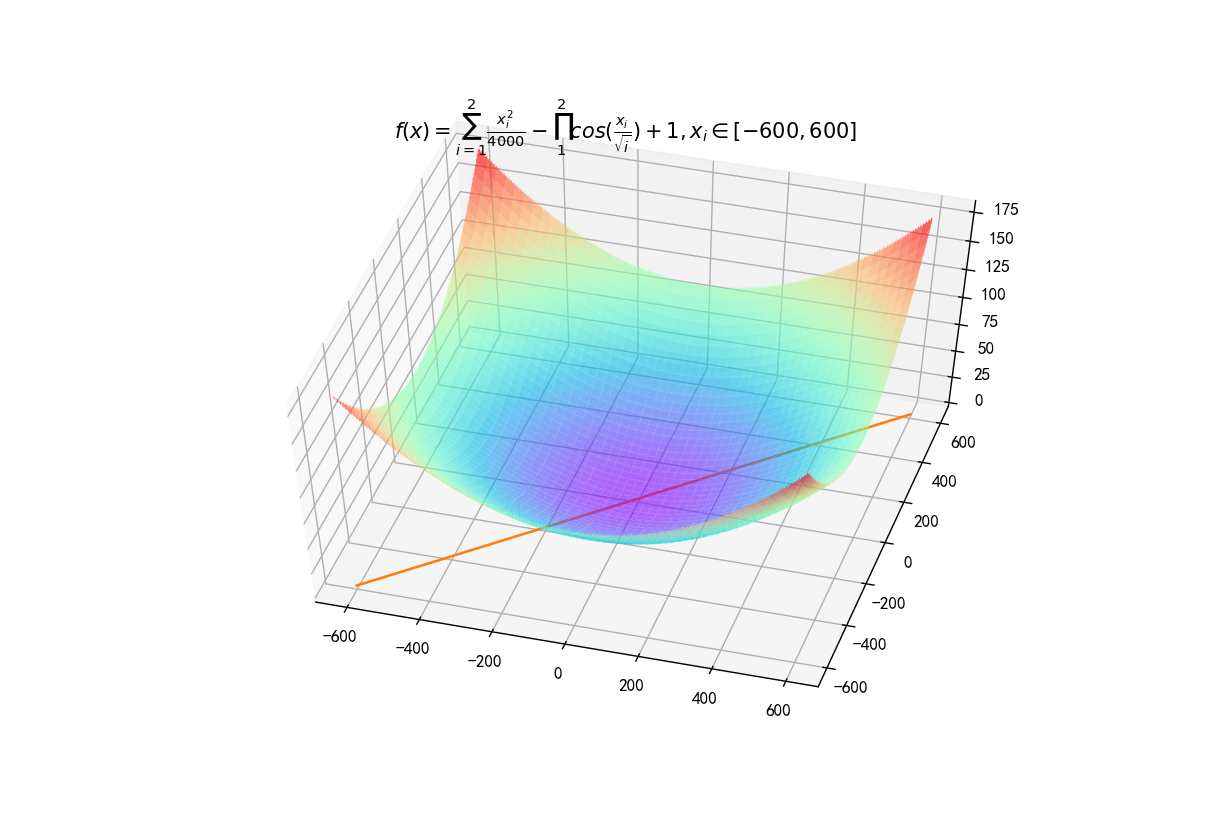

In [27]:
%matplotlib notebook
def Griewank(x):
    return 1+(1/4000)*x[0]**2+(1/4000)*x[1]**2-np.cos(x[0])*np.cos(1/2*x[1]*(2**(1/2)))

fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.arange(-600, 600, 0.1)
y = np.arange(-600, 600, 0.1)
X, Y = np.meshgrid(x, y)
Z = Griewank(np.array([X, Y]))
ax.plot_surface(X, Y, Z, cmap='rainbow', alpha=0.6)
plt.title(r'$f(x)=\sum_{i=1}^{2}\frac{x_i^2}{4000} - \prod_{1}^{2}cos(\frac{x_i}{\sqrt{i}})+1, x_i \in [-600,600]$')
plt.plot(x,y)
plt.show()


<br>$$ {f(x)=\sum_{i=1}^{2}\frac{x_i^2}{4000} - \prod_{1}^{2}cos(\frac{x_i}{\sqrt{i}})+1, x_i \in [-60,60]} $$</br>

<IPython.core.display.Javascript object>


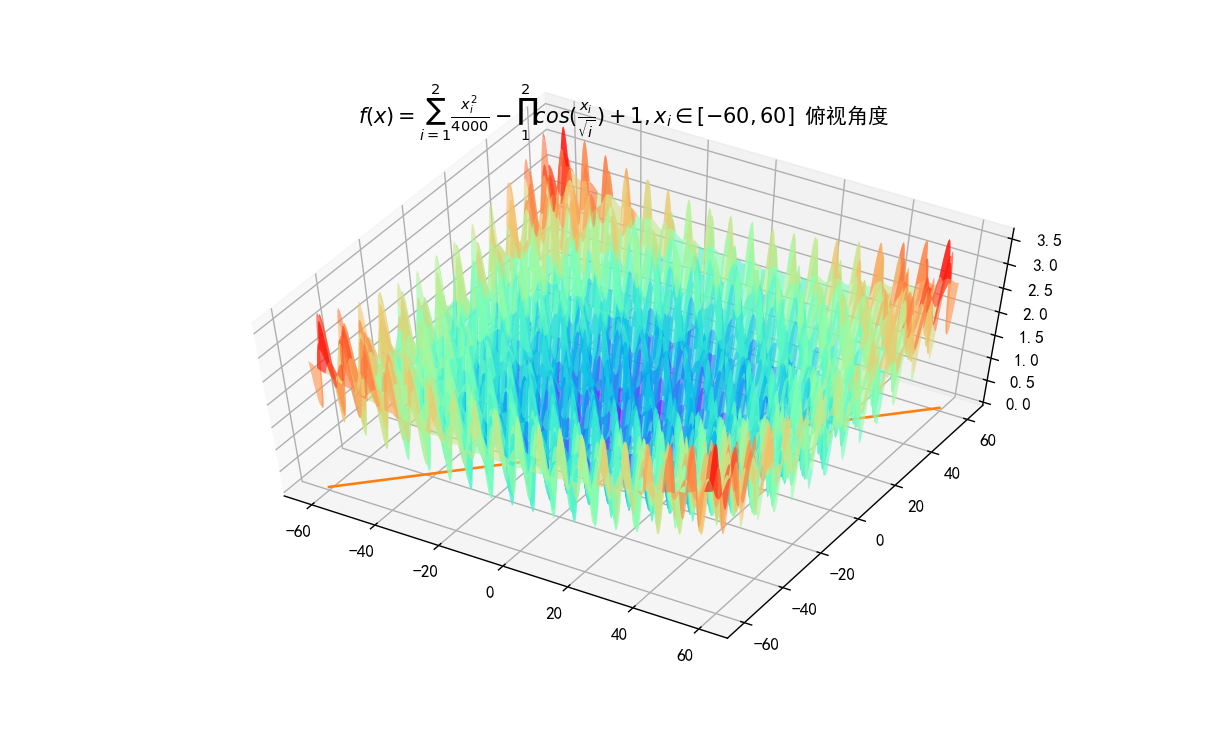

In [28]:
fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.arange(-60, 60, 0.1)
y = np.arange(-60, 60, 0.1)
X, Y = np.meshgrid(x, y)
Z = Griewank(np.array([X, Y]))
ax.plot_surface(X, Y, Z, cmap='rainbow', alpha=0.6)
plt.title(r'$f(x)=\sum_{i=1}^{2}\frac{x_i^2}{4000} - \prod_{1}^{2}cos(\frac{x_i}{\sqrt{i}})+1, x_i \in [-60,60]$ 俯视角度')
plt.plot(x,y)
plt.show()

<IPython.core.display.Javascript object>


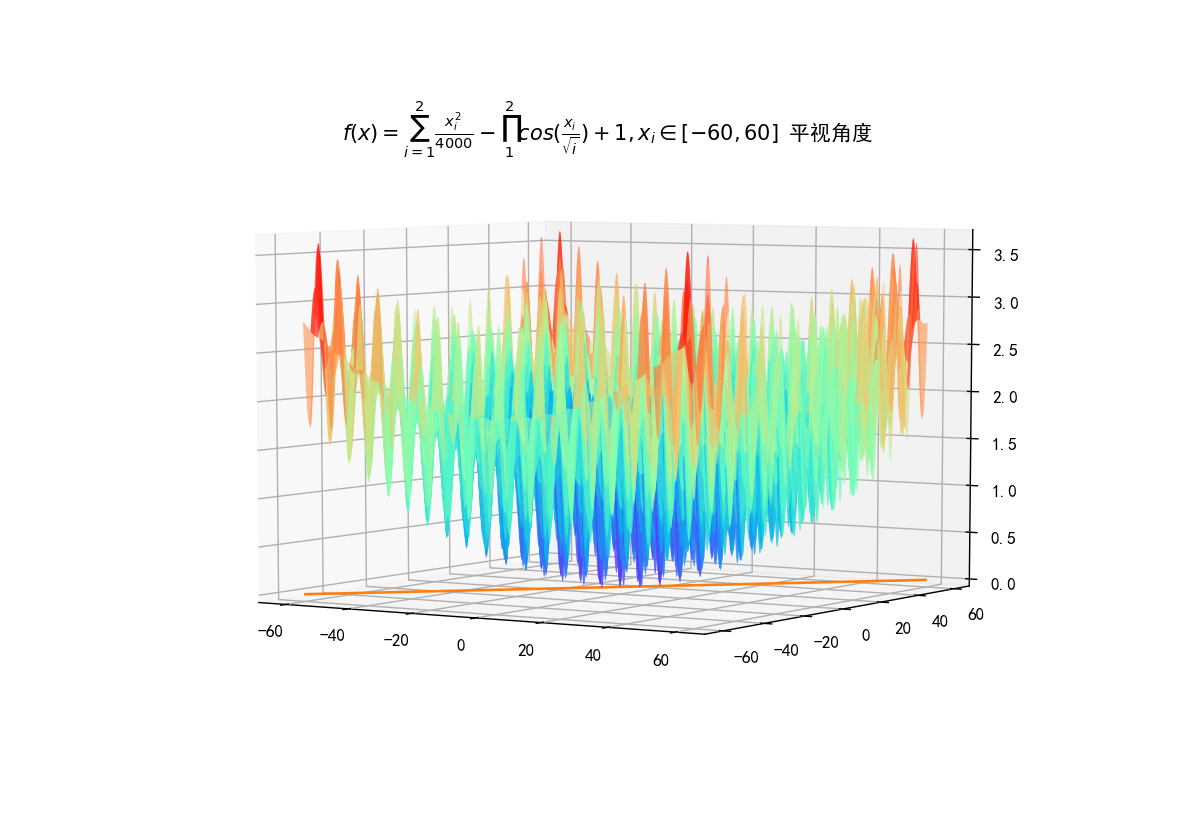

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.arange(-60, 60, 0.1)
y = np.arange(-60, 60, 0.1)
X, Y = np.meshgrid(x, y)
Z = Griewank(np.array([X, Y]))
ax.plot_surface(X, Y, Z, cmap='rainbow', alpha=0.6)
plt.title(r'$f(x)=\sum_{i=1}^{2}\frac{x_i^2}{4000} - \prod_{1}^{2}cos(\frac{x_i}{\sqrt{i}})+1, x_i \in [-60,60]$ 平视角度')
plt.plot(x,y)
plt.show()

<br>$$ {f(x)=\sum_{i=1}^{2}\frac{x_i^2}{4000} - \prod_{1}^{2}cos(\frac{x_i}{\sqrt{i}})+1, x_i \in [-6,6]} $$</br>

<IPython.core.display.Javascript object>


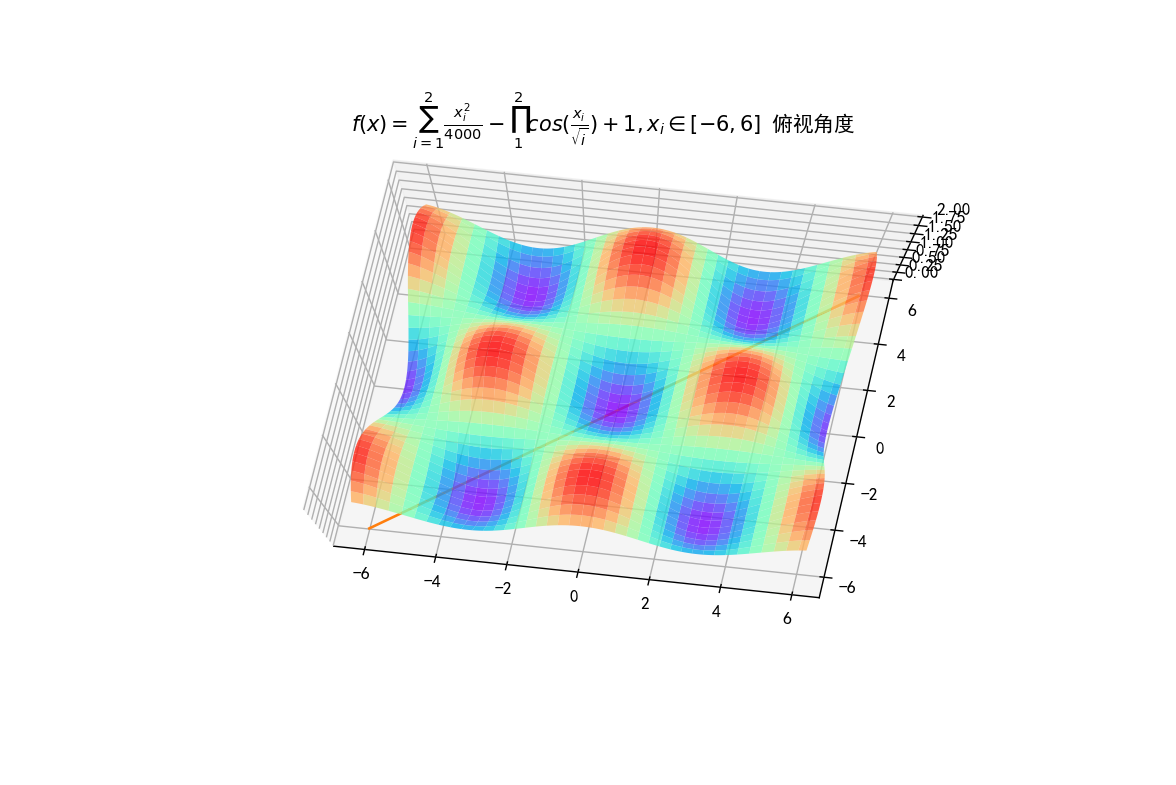

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.arange(-6, 6, 0.1)
y = np.arange(-6, 6, 0.1)
X, Y = np.meshgrid(x, y)
Z = Griewank(np.array([X, Y]))
ax.plot_surface(X, Y, Z, cmap='rainbow', alpha=0.8)
plt.title(r'$f(x)=\sum_{i=1}^{2}\frac{x_i^2}{4000} - \prod_{1}^{2}cos(\frac{x_i}{\sqrt{i}})+1, x_i \in [-6,6]$ 俯视角度')
plt.plot(x,y)
plt.show()

<br><font size=5 >**函数选择(4/4)**</font><br/>
<br><br/>
	<br>&emsp;&emsp;**函数名：Rastrigin**<br/>
   <br>$$ \boxed{f(x,y)=20+x^2-10cos(2\pi x)+y^2-10cos(2\pi y)} $$</br>
   <br></br>
	<br>&emsp;&emsp;**函数特征**</br>
	<br>&emsp;&emsp;&emsp;&emsp;该函数内存在一个余弦调制传递函数来产生频繁的局部极小值</br>
	<br></br>
   <br>&emsp;&emsp;**极小值点**</br>
	<br>&emsp;&emsp;&emsp;&emsp;全局最小值$ f(0,0)=0 $</br>
	<br></br>
	<br>&emsp;&emsp;**测试性能**<br>
   <br>&emsp;&emsp;&emsp;&emsp;适合用于判断算法在规律分布的局部极小值的函数中的表现。</br>

<br> $$f(x,y)=20+x^2-10cos(2\pi x)+y^2-10cos(2\pi y),   x,y \in [-5,5] $$ </br>

<IPython.core.display.Javascript object>


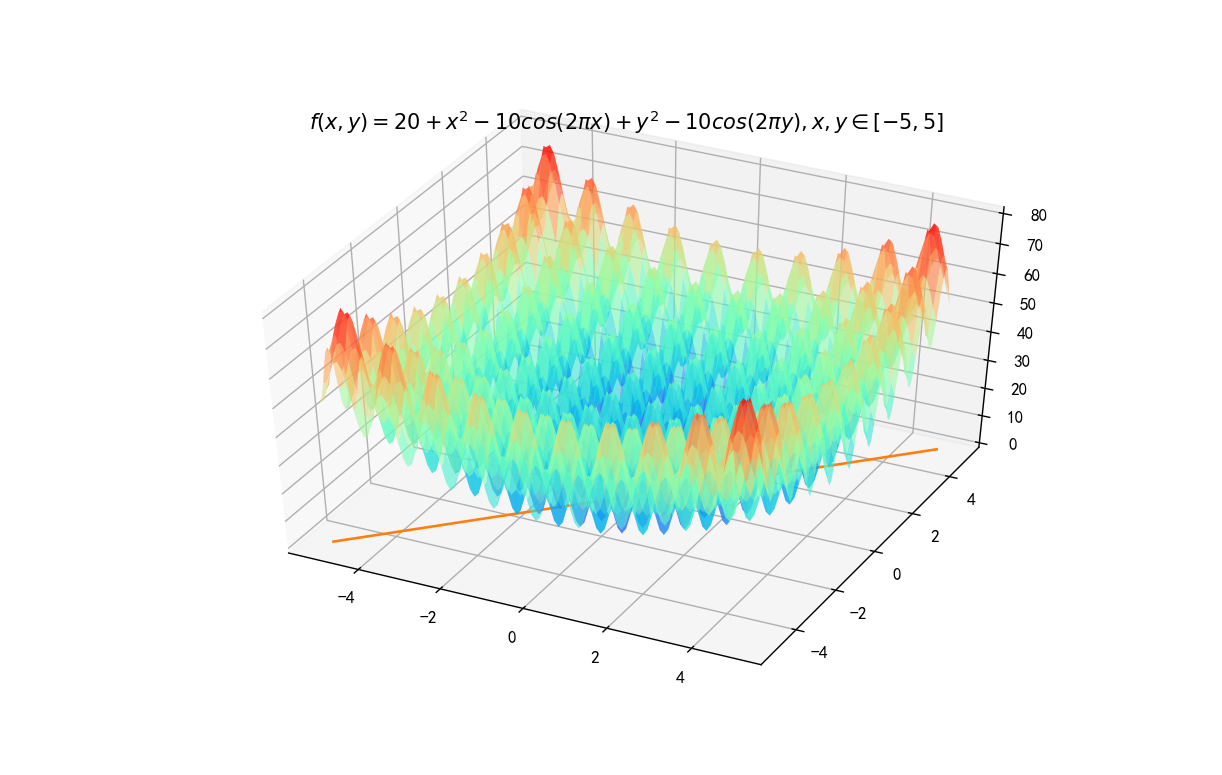

In [9]:
%matplotlib notebook
def Rastrigrin(x: np.ndarray):
    return 20 + x[0]**2 - 10*np.cos(2*np.pi*x[0]) + x[1]**2 - 10*np.cos(2*np.pi*x[1])

fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(x, y)
Z = Rastrigrin(np.array([X, Y]))
ax.plot_surface(X, Y, Z, cmap='rainbow', alpha=0.6)
plt.title(r'$f(x,y)=20+x^2-10cos(2\pi x)+y^2-10cos(2\pi y), x,y \in [-5,5]$')
plt.plot(x,y)
plt.show()

Number of iteration:  17700
Cooled to final temperature
(array([0.89388878]), -15.878706815584835)


<IPython.core.display.Javascript object>


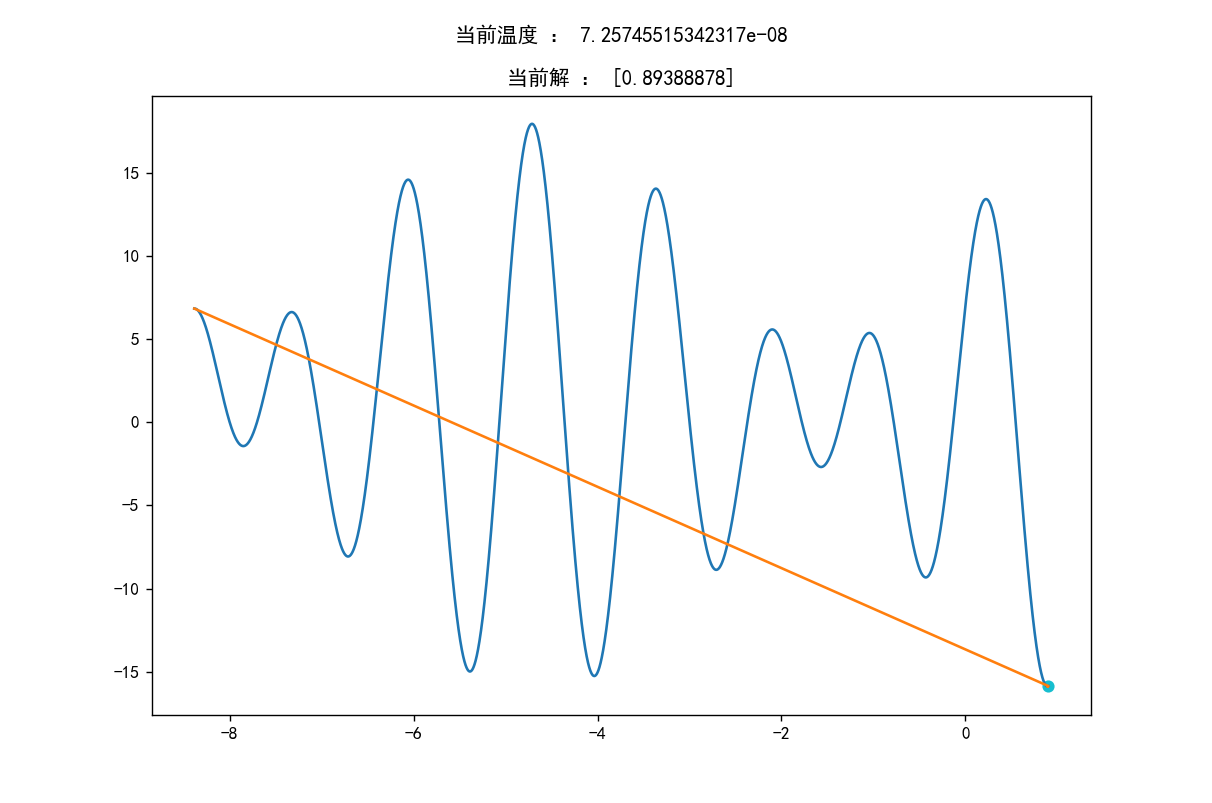

<IPython.core.display.Javascript object>


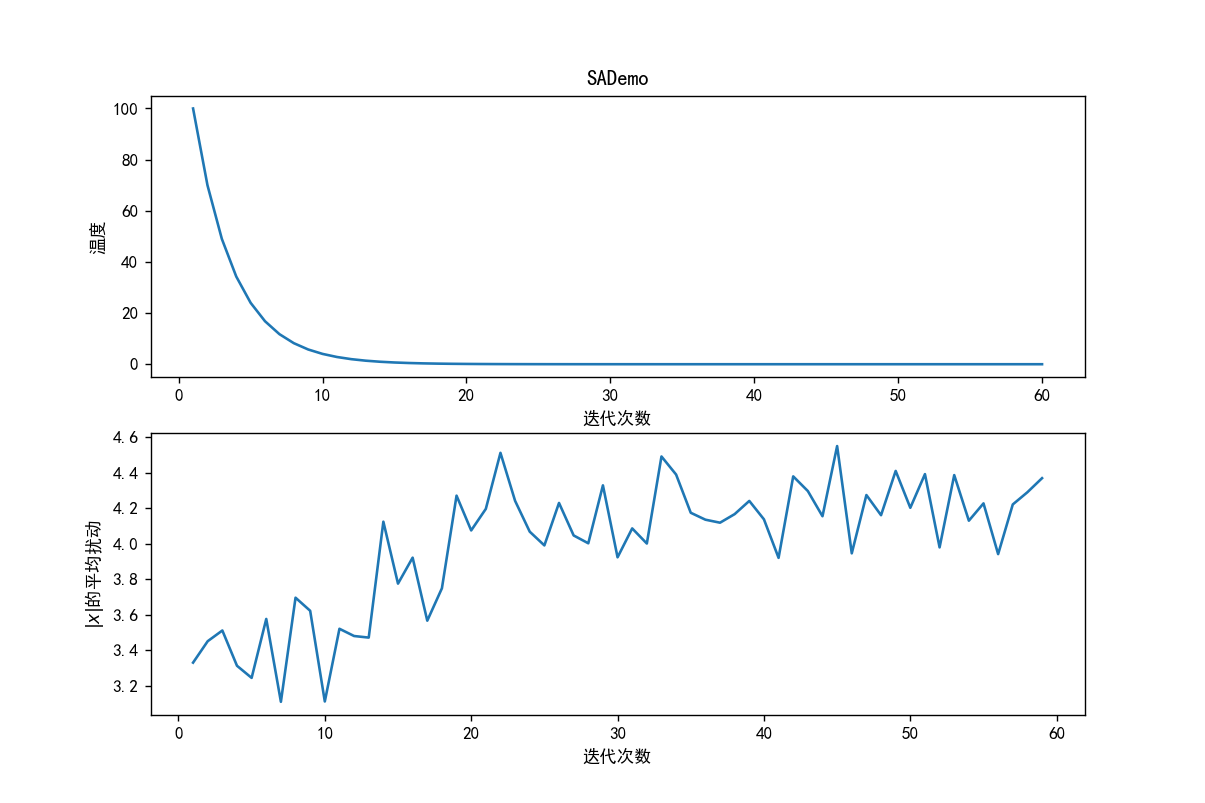

In [10]:
x_min = np.array([-10])
x_max = np.array([10])
demo = SADemo(obj_fun1, x_min, x_max)
print(demo.run())
demo.draw()
demo.plot()

Number of iteration:  17700
Cooled to final temperature
(array([2.82091851e-05]), 1.578721153805418e-08)


<IPython.core.display.Javascript object>


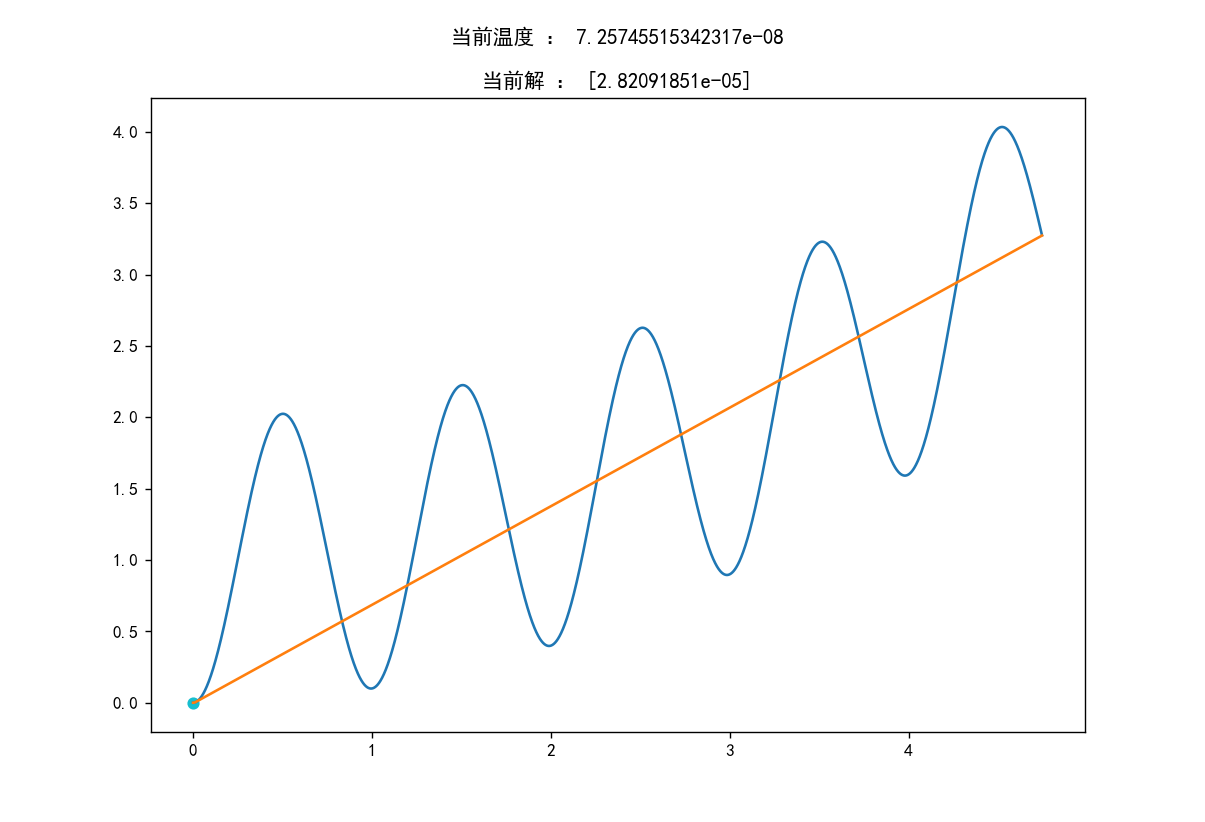

<IPython.core.display.Javascript object>


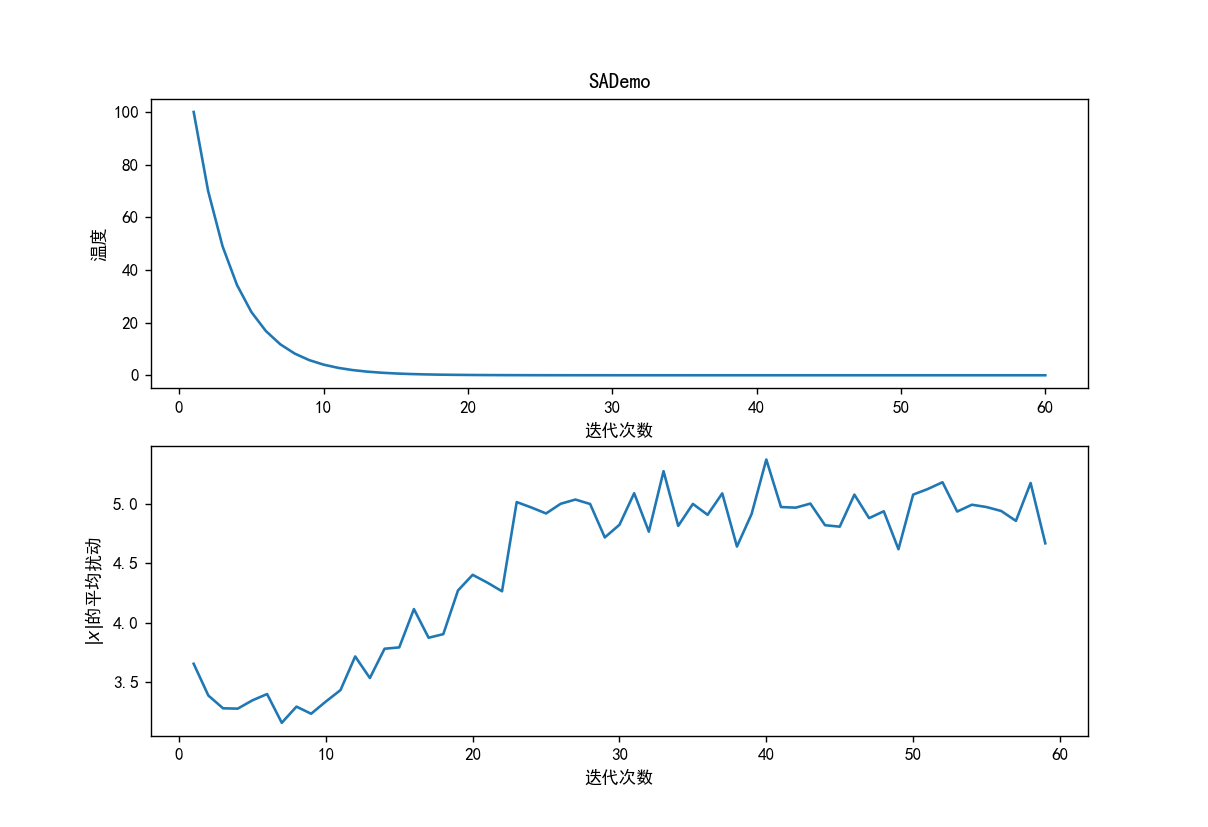

In [11]:
x_min = np.array([-10])
x_max = np.array([10])
demo = SADemo(obj_fun2, x_min, x_max)
print(demo.run())
demo.draw()
demo.plot()

Number of iteration:  17700
Cooled to final temperature
(array([ 8.91419074, 13.08994787]), 0.2026429715062842)


<IPython.core.display.Javascript object>


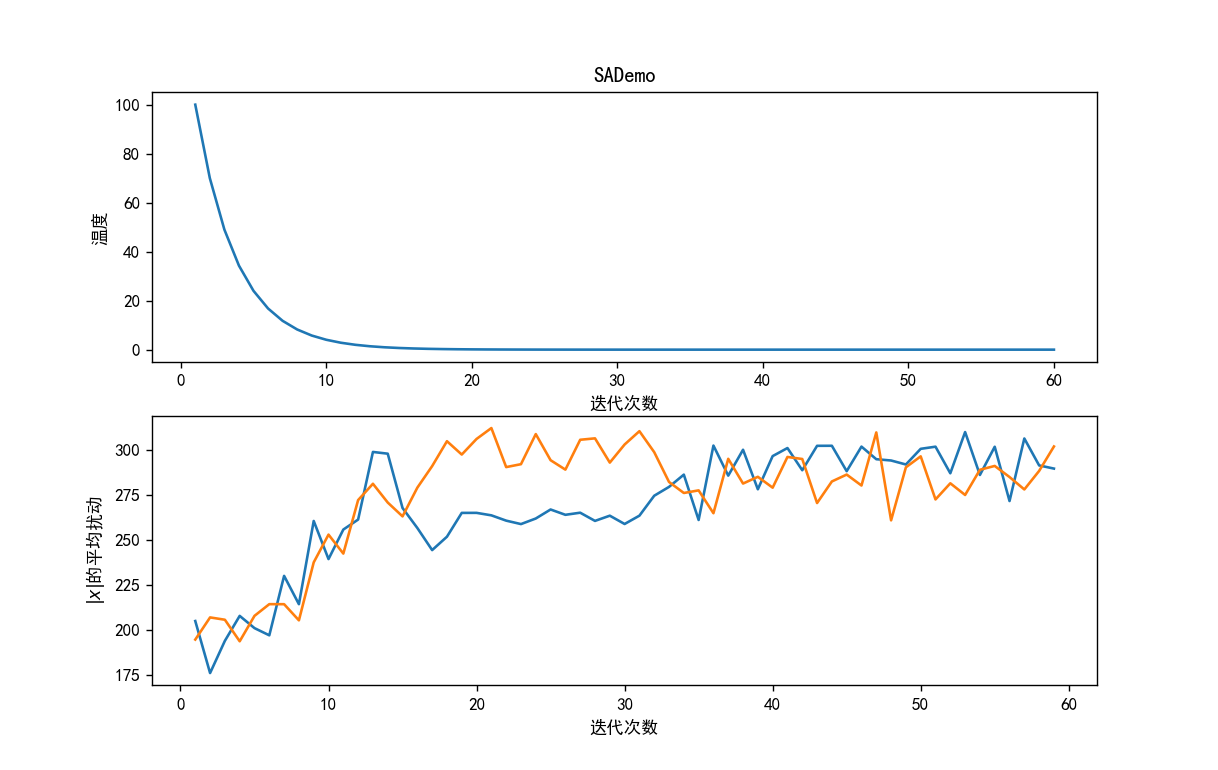

In [14]:
x_min = np.array([-600, -600])
x_max = np.array([600, 600])
demo = SADemo(Griewank, x_min, x_max)
print(demo.run())
# demo.draw()
demo.plot()

Number of iteration:  17700
Cooled to final temperature
(array([0.02908991, 0.02373163]), 0.2789459896758988)


<IPython.core.display.Javascript object>


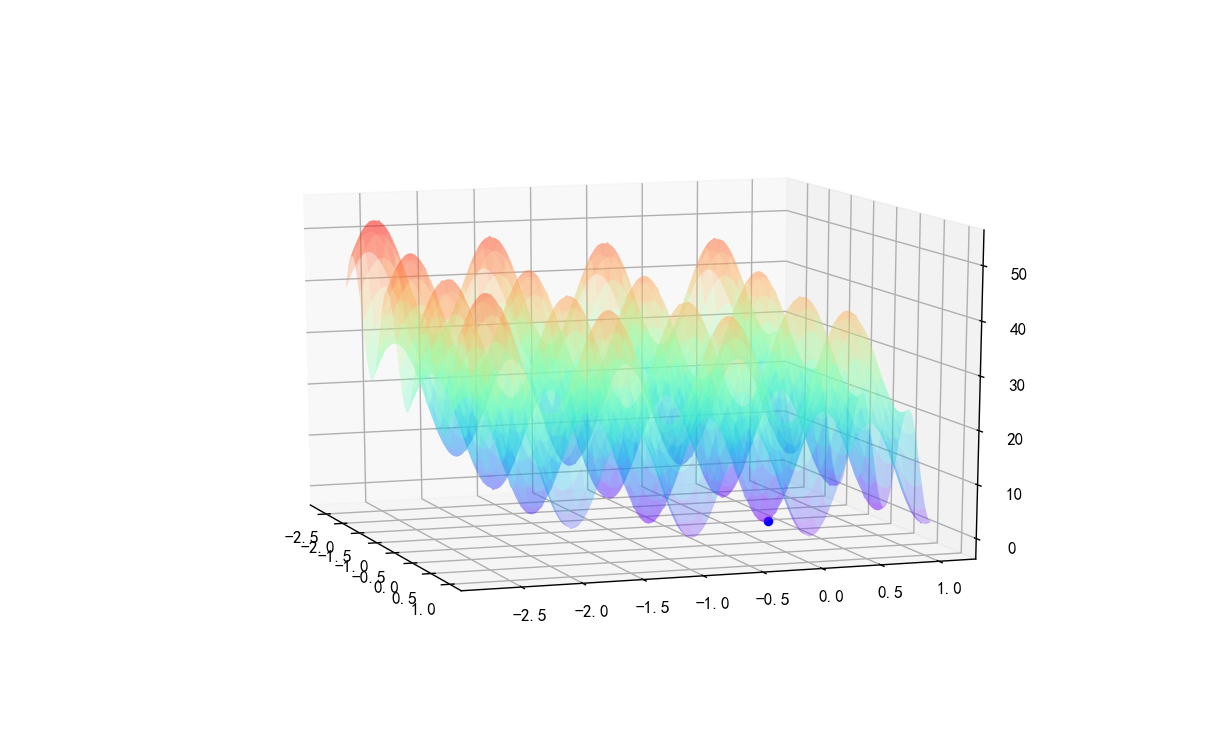

<IPython.core.display.Javascript object>


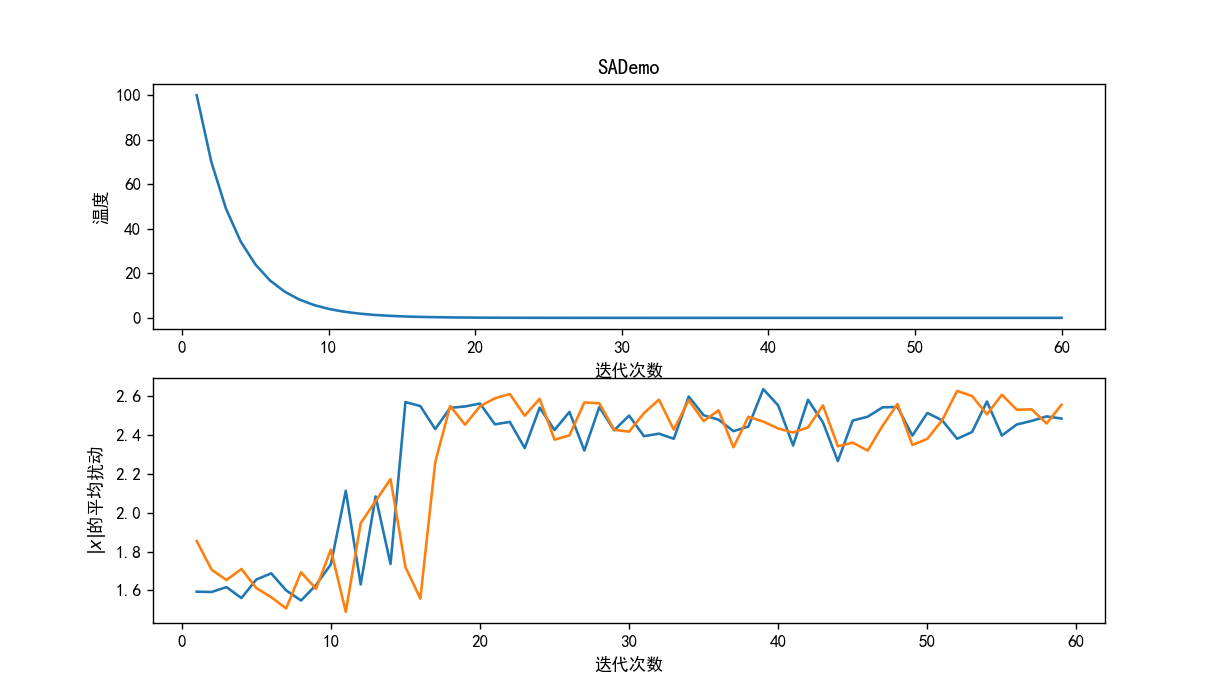

In [13]:
x_min = np.array([-5, -5])
x_max = np.array([5, 5])
demo = SADemo(Rastrigrin, x_min, x_max)
print(demo.run())
demo.draw()
demo.plot()

<br><font size=5 >**对Griewangk和函数Rastrigin函数的优化效果进行改进**</font></br>
<br></br>
<br>&emsp;&emsp;**初始温度$T_{max}$**</br>
<br>&emsp;&emsp;&emsp;&emsp;$T_{max}$越大&emsp;--->&emsp;准确率和精确度越高，相应地，计算时间会变长</br>
<br>$$ \boxed{T_0 = 10^5} $$</br>
<br></br>
<br>&emsp;&emsp;**终止温度$T_{min}$**</br>
<br>&emsp;&emsp;&emsp;&emsp;$T_{min}$*越小&emsp;--->&emsp;搜索时间越长，精确度越高</br>
<br>$$ \boxed{T_{min} = 10^{-10}} $$</br>
<br></br>
<br>&emsp;&emsp;**降温系数$\alpha$**</br>
<br>&emsp;&emsp;&emsp;&emsp;$\alpha$越大&emsp;--->&emsp;降温越慢，准确率和精确度越高</br>
<br>$$ \boxed{\alpha = 0.9} $$</br>
<br></br>
<br>&emsp;&emsp;**马尔科夫链长度$L$**</br>
<br>&emsp;&emsp;&emsp;&emsp;$L$越大&emsp;--->&emsp;等温阶段寻解次数越多，准确率和精确度越高</br>
<br>$$ \boxed{L = 0.9} $$</br>

Number of iteration:  164000
Cooled to final temperature
(array([3.10242595, 4.97790809]), 0.08002733744495061)


<IPython.core.display.Javascript object>


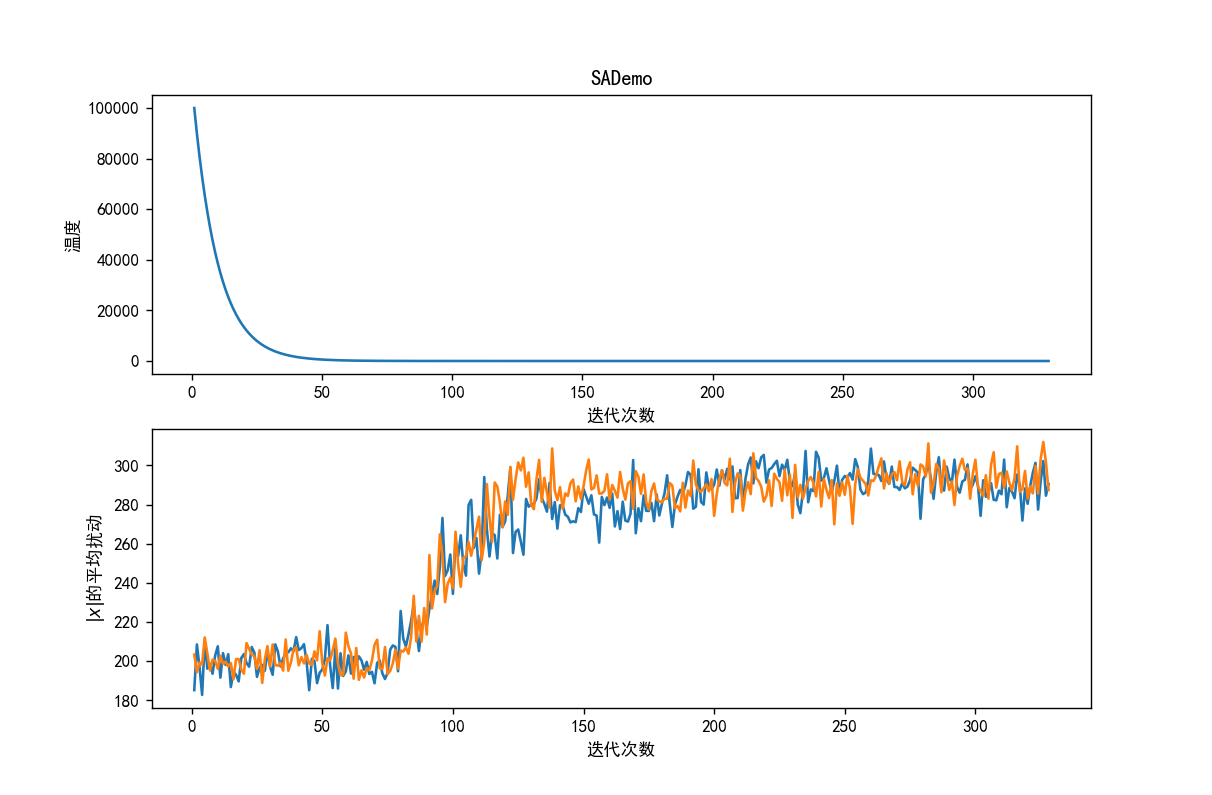

In [15]:
x_min = np.array([-600, -600])
x_max = np.array([600, 600])
demo = SADemo(Griewank, x_min, x_max, T_max=1e5, T_min=1e-10, L=500, alpha=0.9)
print(demo.run())
# demo.draw()
demo.plot()

Number of iteration:  164000
Cooled to final temperature
(array([0.00728694, 0.00889655]), 0.026231081826447067)


<IPython.core.display.Javascript object>


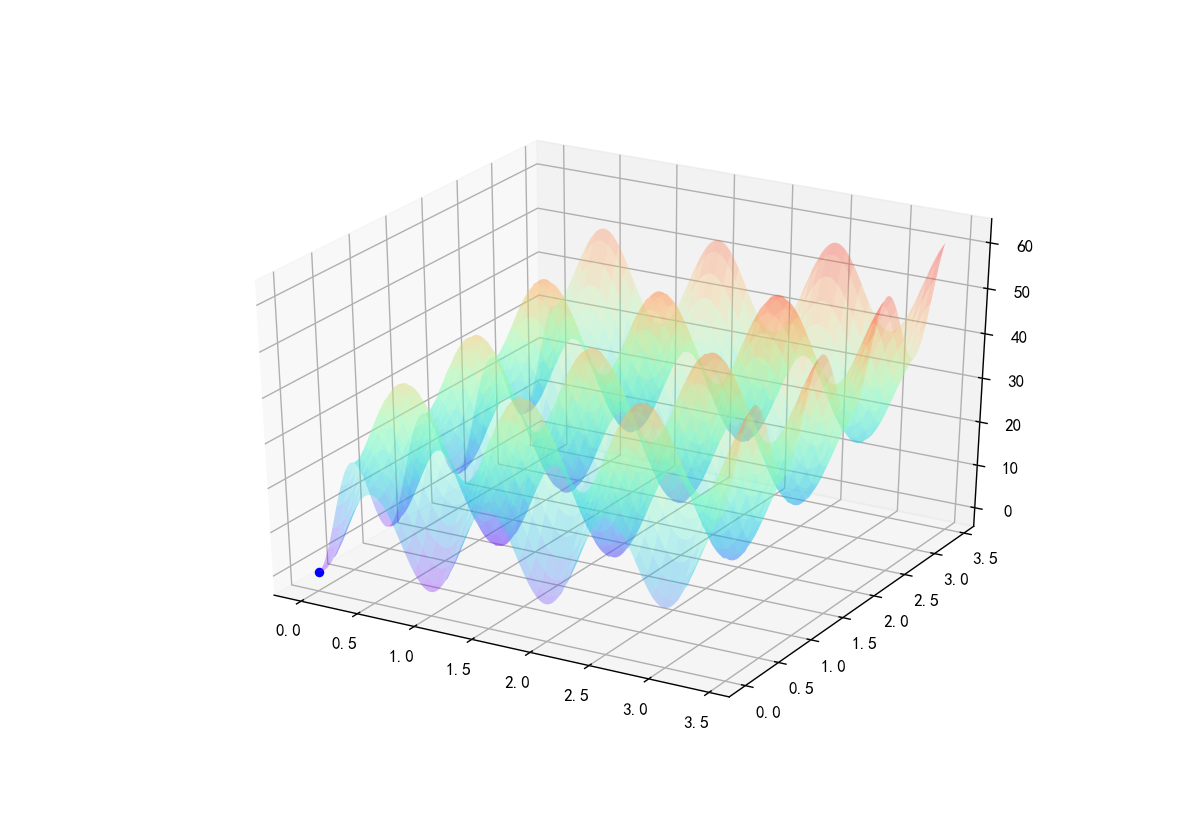

<IPython.core.display.Javascript object>


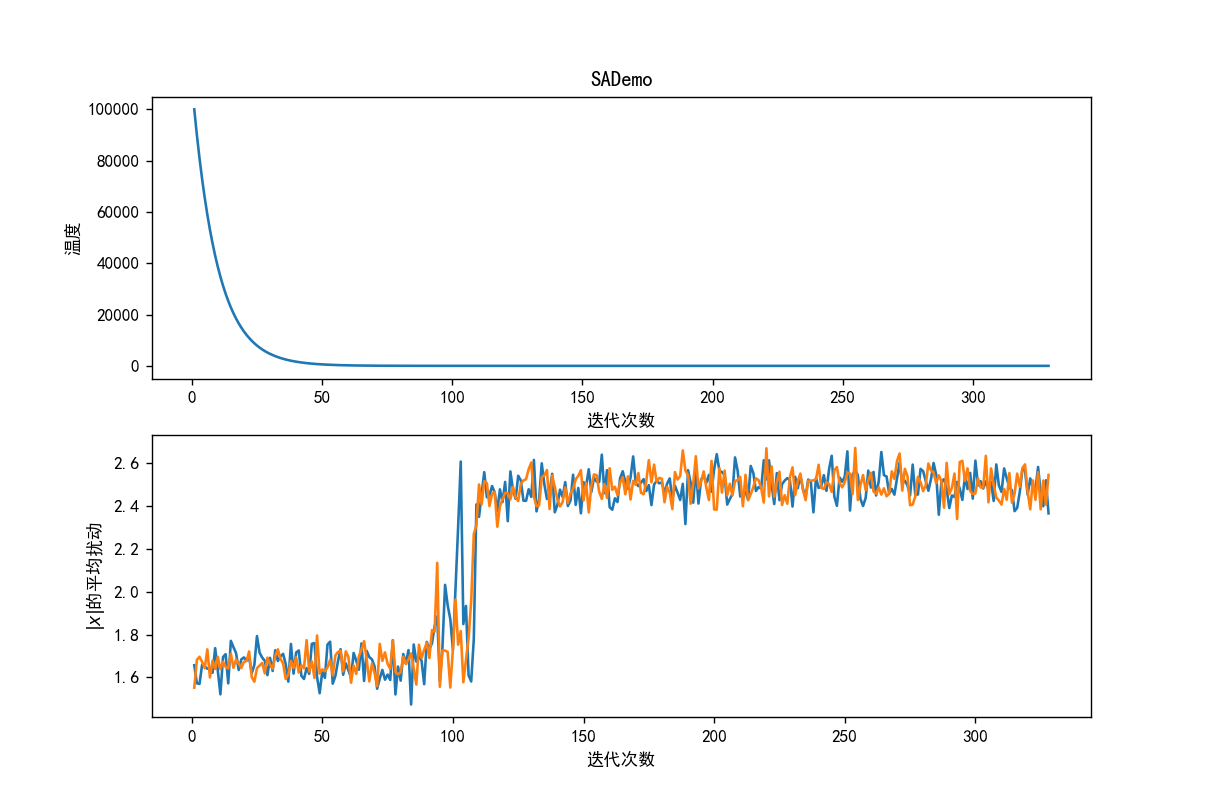

In [18]:
x_min = np.array([-5, -5])
x_max = np.array([5, 5])
demo = SADemo(Rastrigrin, x_min, x_max, T_max=1e5, T_min=1e-10, L=500, alpha=0.9)
print(demo.run())
demo.draw()
demo.plot()

<br><font size=5 >**对产生新解的方式$\text{get_new_x()}$进行改进**</font></br>
<br></br>
<br>&emsp;&emsp;**核心思想**</br>
<br>&emsp;&emsp;&emsp;&emsp;搜索前期应该具有全空间分散性，搜索后期应该具有局部区域性</br>
<br></br>
<br></br>
<br>&emsp;&emsp;**对比常见的三种随机分布，搜索区间为$(-10,10)$**</br>
<br>&emsp;&emsp;**均匀分布**</br>
<br>$$ \boxed{Uniform:p(x)=\frac{1}{20}} $$</br>
<br>&emsp;&emsp;**正态分布**</br>
<br>$$ \boxed{Normal:p(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}} $$</br>
<br>&emsp;&emsp;**柯西分布**</br>
<br>$$ \boxed{Cauchy:p(x)=\frac{1}{\pi(1+x^2)}} $$</br>
<br></br>


<IPython.core.display.Javascript object>


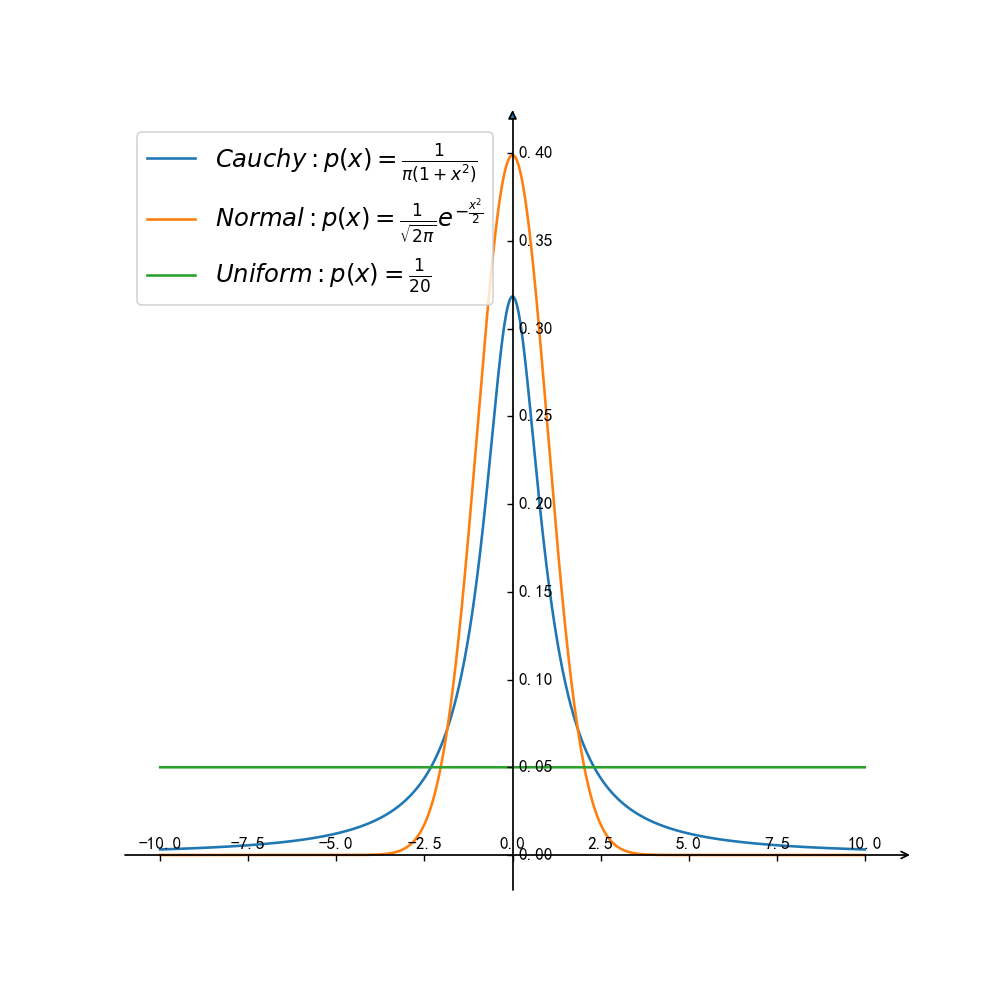

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist

def Cauchy(x):
    return 1 / (1 + x**2) / np.pi

def Normal(x):
    sigma = 1
    return (1/((2*np.pi)**0.5*sigma)) * np.exp(-1*x**2 / (2 * sigma**2))


x = np.arange(-10, 10, 0.001)
vCauchy = np.vectorize(Cauchy)
vNormal = np.vectorize(Normal)
yCauchy = vCauchy(x)
yNormal = vNormal(x)
yUniform = np.zeros(shape=x.shape) + 0.05


#创建画布
fig = plt.figure(figsize=(8, 8))
#使用axisartist.Subplot方法创建一个绘图区对象ax
ax = axisartist.Subplot(fig, 111)
#将绘图区对象添加到画布中
fig.add_axes(ax)

#通过set_visible方法设置绘图区所有坐标轴隐藏
ax.axis[:].set_visible(False)

#ax.new_floating_axis代表添加新的坐标轴
ax.axis["x"] = ax.new_floating_axis(0,0)
#给x坐标轴加上箭头
ax.axis["x"].set_axisline_style("->", size = 1.0)
#添加y坐标轴，且加上箭头
ax.axis["y"] = ax.new_floating_axis(1,0)
ax.axis["y"].set_axisline_style("-|>", size = 1.0)
#设置x、y轴上刻度显示方向
ax.axis["x"].set_axis_direction("top")
ax.axis["y"].set_axis_direction("right")

font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 14,
}

ax.plot(x, yCauchy, label=r'$Cauchy:p(x)=\frac{1}{\pi(1+x^2)}$')
ax.plot(x, yNormal, label=r'$Normal:p(x)=\frac{1}{\sqrt{2\pi}}e^{\frac{x^2}{2}}$')
ax.plot(x, yUniform, label=r'$Uniform:p(x)=\frac{1}{20}$')
ax.legend([r'$Cauchy:p(x)=\frac{1}{\pi(1+x^2)}$',
           r'$Normal:p(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$',
           r'$Uniform:p(x)=\frac{1}{20}$']
          ,prop=font1)

plt.show()

In [20]:
class SAMixed(SimulatedAnnealingBase):
    def __init__(self, func, x_min, x_max, T_max=1e2, T_min=1e-7, L=300, max_stay_counter=500, alpha=0.95, **kwargs):
        super().__init__(func, x_min, x_max, T_max, T_min, L, max_stay_counter, alpha, **kwargs)
        self.name = 'SAMixed'

    def get_new_x(self, x_old):
        x_new = np.zeros(shape=x_old.shape)
        for i in range(x_old.shape[0]):
            if self.T > 1e-4:
                u = np.random.uniform(-1,1)
            elif self.T >1e-6:
                u = np.random.standard_cauchy()
            else:
                u = np.random.standard_normal()
            delta = (u - 0.5) * (self.x_max[i] - self.x_min[i]) * np.sqrt(self.T)
            x_new[i] = x_old[i] + delta
            if x_new[i] < (self.x_min[i] + 10e-4) or (10e-4 + x_new[i]) > self.x_max[i]:
                x_new[i] = x_new[i] - 2 * delta
        return x_new

Number of iteration:  188700
Cooled to final temperature
(array([-4.53552083e-06,  1.13974883e-05]), 4.2798653510089935e-11)


<IPython.core.display.Javascript object>


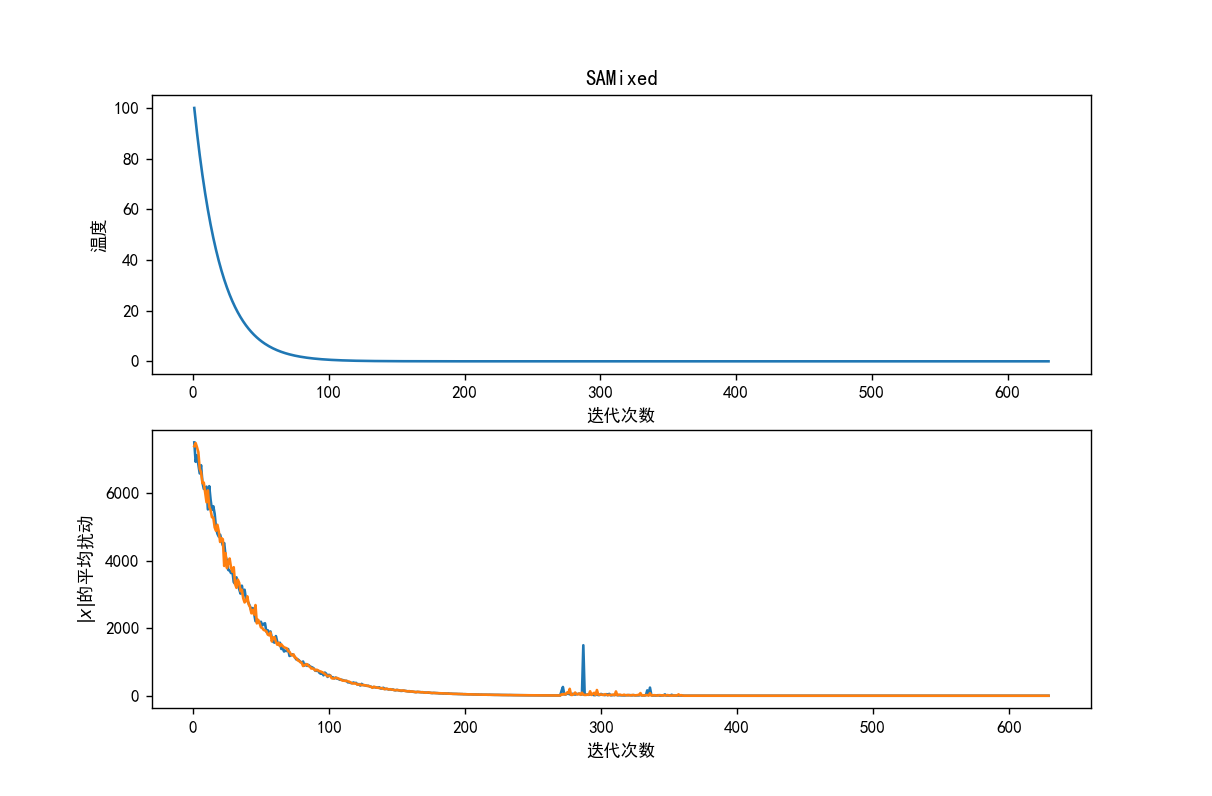

In [21]:
x_min = np.array([-600, -600])
x_max = np.array([600, 600])
demo = SAMixed(Griewank, x_min, x_max, T_min = 1e-12)
print(demo.run())
# demo.draw()
demo.plot()

Number of iteration:  164000
Cooled to final temperature
(array([-1.35601434e-06, -6.01020112e-08]), 3.6551561777287134e-10)


<IPython.core.display.Javascript object>


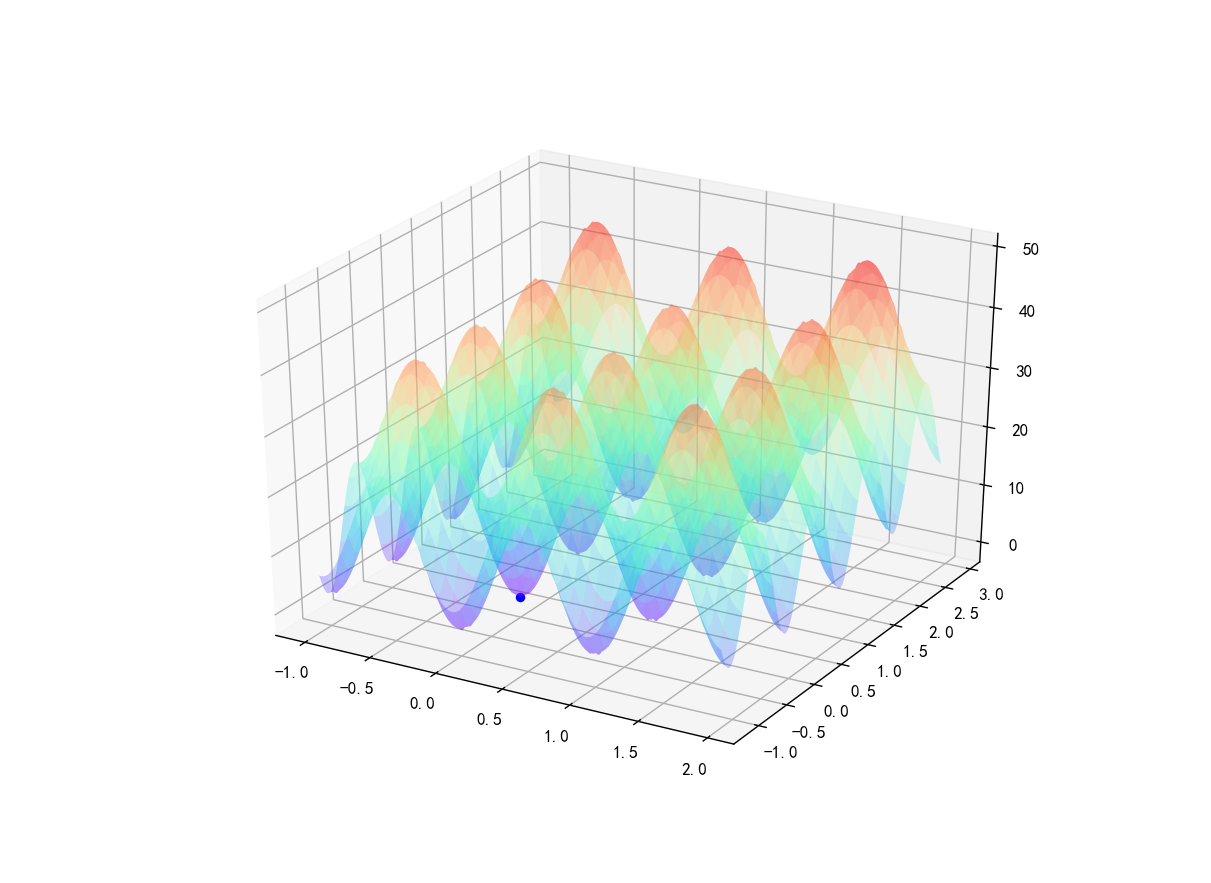

<IPython.core.display.Javascript object>


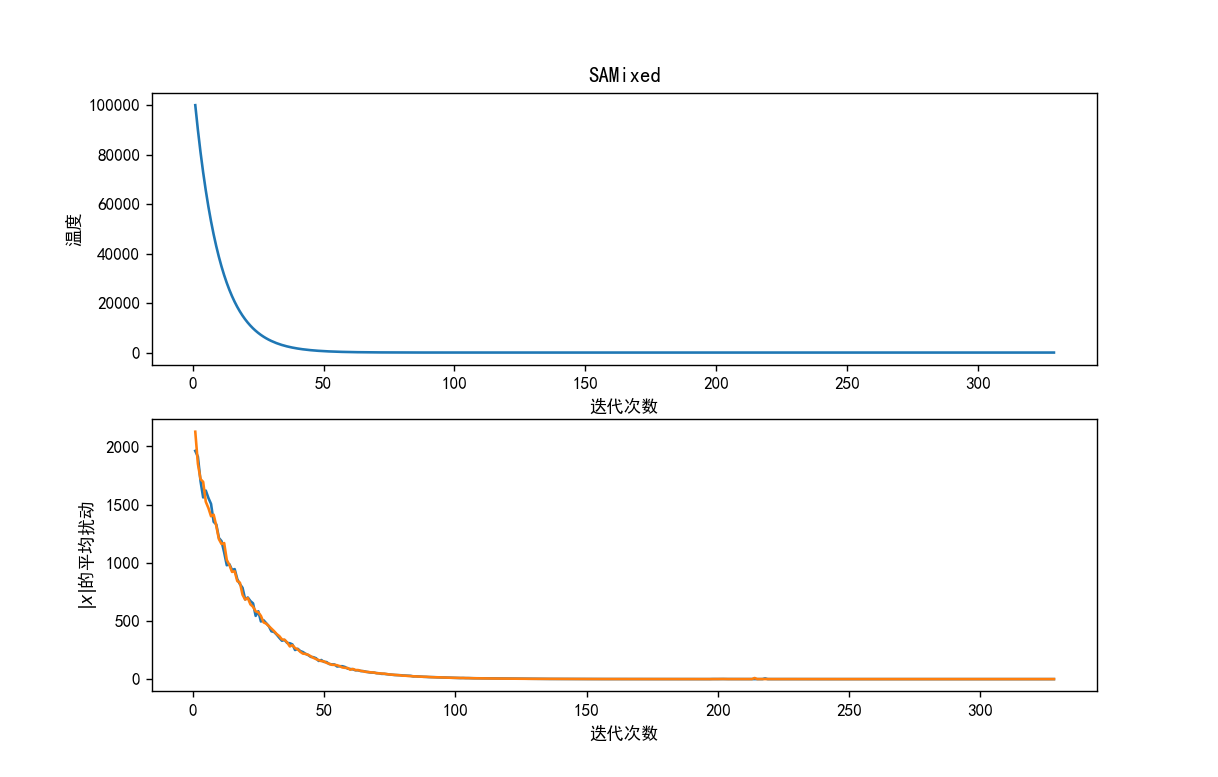

In [22]:
x_min = np.array([-5, -5])
x_max = np.array([5, 5])
demo = SAMixed(Rastrigrin, x_min, x_max, T_max=1e5, T_min=1e-10, L=500, alpha=0.9)
print(demo.run())
demo.draw()
demo.plot()